In [5]:
import pandas as pd
import numpy as np
import sklearn.datasets as ds
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import shap
shap.initjs()

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
sns.set()

# Leitura dos Dados

Como ainda não há nenhum dado, vou pegar um dataset arbitrário aqui

In [6]:
def load_dataset(path):
    """
    Load dataset from file.

    The target variable must be in column named "target".

    Parameters
    ----------
    path: str
        path to file

    Returns
    -------
    dataset: pd.DataFrame
    """
    data = ds.load_diabetes(as_frame=True)
    dataset = data["frame"]
    dataset.insert(0, "player_id", np.random.choice(range(1, 30), len(dataset)))
    return dataset

In [4]:
dataset = pd.read_csv('input_data_2.csv',index_col=0)
dataset

,game_id,home_team,away_team,player,team,pos,player_age,time_played,shots_on_target,goals,...,xg,xag,result,last_xg,last_xag,days_from_last_game,played_at_home,Season_End_Year,game_id_y,action_value
0,bf52349b,Fulham,Arsenal,Ainsley Maitland-Niles,Arsenal,LM,23,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,14.0,False,2022,bf52349b,0.017502
1,bf52349b,Fulham,Arsenal,Alexandre Lacazette,Arsenal,FW,29,0.0,0.0,0.0,...,0.9,0.1,0,0.0,0.0,14.0,False,2022,bf52349b,-0.015915
2,bf52349b,Fulham,Arsenal,Bernd Leno,Arsenal,GK,28,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,14.0,False,2022,bf52349b,-0.017149
3,bf52349b,Fulham,Arsenal,Dani Ceballos,Arsenal,CM,24,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,14.0,False,2022,bf52349b,0.023188
4,bf52349b,Fulham,Arsenal,Eddie Nketiah,Arsenal,FW,21,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,14.0,False,2022,bf52349b,0.000589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9898,2c081c94,Wolves,Manchester Utd,Romain Saiss,Wolverhampton Wanderers,CB,31,90.0,1.0,0.0,...,0.1,0.0,lose,0.2,0.0,7.0,False,2022,2c081c94,0.192526
9899,2c081c94,Wolves,Manchester Utd,Rui Patricio,Wolverhampton Wanderers,GK,33,90.0,0.0,0.0,...,0.0,0.0,lose,0.0,0.0,7.0,False,2022,2c081c94,0.007129
9900,2c081c94,Wolves,Manchester Utd,Ruben Neves,Wolverhampton Wanderers,CM,24,90.0,0.0,0.0,...,0.1,0.1,lose,0.0,0.0,3.0,False,2022,2c081c94,0.514115
9901,2c081c94,Wolves,Manchester Utd,Willian Jose,Wolverhampton Wanderers,FW,29,23.0,0.0,0.0,...,0.2,0.0,lose,0.0,0.0,3.0,False,2022,2c081c94,0.056681


In [35]:
matches_with_weather = pd.read_pickle('bkp_matches_w_weather.pkl')
matches_with_weather.describe()

,Season_End_Year,Wk,HomeGoals,AwayGoals,Capacity,Latitude,Longitude,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,7876.000000,7876.000000,7876.000000,7876.000000,7876.000000,7876.000000,7876.000000,7876.000000,7580.000000,7617.000000,3676.000000,84.000000,6116.000000,7399.000000,1511.000000,5844.000000,0.0
mean,2009.380777,19.738065,1.596369,1.110843,41173.497715,52.423881,-1.229063,9.075521,5.803509,12.386793,2.177203,38.916667,198.792675,14.554061,34.104765,1014.422861,NaN
std,9.126978,11.095846,1.344423,1.130486,14064.555641,1.097833,1.203479,4.791916,4.757450,5.456316,4.165222,173.869859,89.964995,7.039785,13.421393,11.947848,NaN
min,1993.000000,1.000000,0.000000,0.000000,16220.000000,50.861822,-3.935100,-8.100000,-10.800000,-2.900000,0.000000,0.000000,0.000000,0.000000,11.100000,901.000000,NaN
25%,2002.000000,10.000000,1.000000,0.000000,32500.000000,51.531944,-2.200292,5.600000,2.400000,8.500000,0.000000,0.000000,149.000000,9.500000,24.100000,1006.600000,NaN
50%,2010.000000,20.000000,1.000000,1.000000,40157.000000,52.448056,-1.391111,8.900000,5.700000,12.000000,0.300000,10.000000,215.000000,13.600000,31.500000,1015.400000,NaN
75%,2017.000000,29.000000,2.000000,2.000000,47405.000000,53.438889,-0.108611,12.300000,9.100000,16.100000,2.400000,20.000000,261.000000,18.400000,40.800000,1023.000000,NaN
max,2023.000000,42.000000,9.000000,9.000000,75811.000000,54.975556,1.308653,25.200000,21.200000,32.400000,37.800000,1181.000000,360.000000,74.500000,109.000000,1044.900000,NaN


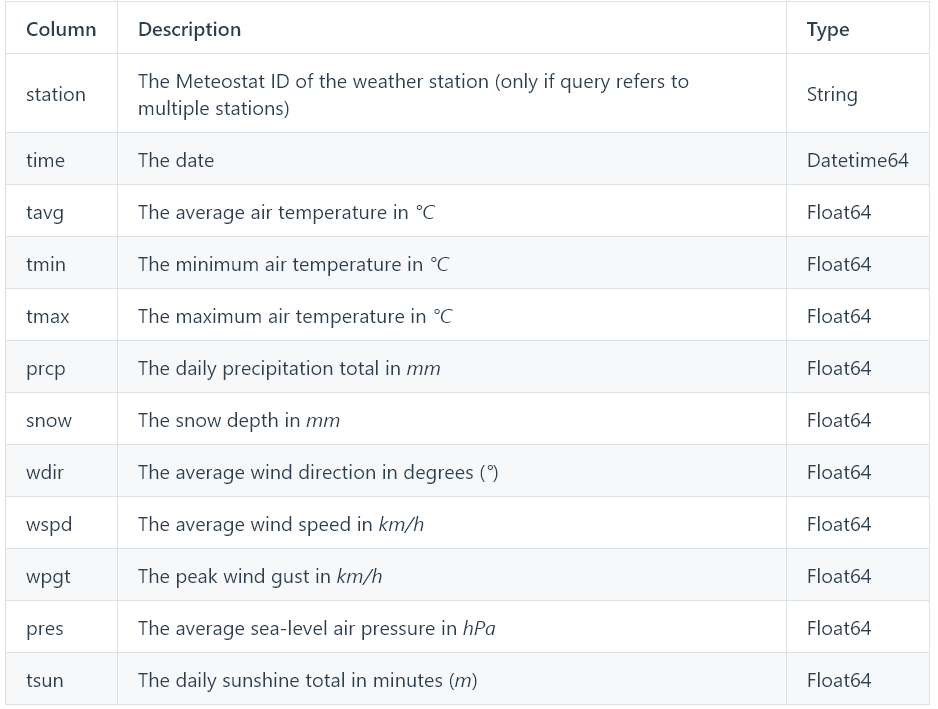

In [36]:
dataset = pd.read_csv('input_data_2.csv',index_col=0)
matches_with_weather = pd.read_pickle('bkp_matches_w_weather.pkl')
dataset = dataset.merge(matches_with_weather,left_on=['home_team', 'away_team', 'Season_End_Year'], right_on=['Team','Away', 'Season_End_Year'], how='inner')
dataset.drop(columns=['home_team', 'away_team', 'team', 'Team', 'Away', 'FDCOUK', 'FTR', 'stadium', 'Date'], inplace=True)
dataset.drop(columns=['tsun', 'Country', 'Stadium','City', 'HomeGoals', 'AwayGoals', 'date', 'Season_End_Year', 'Latitude', 'Longitude'], inplace=True)

dataset[['snow', 'wpgt', 'prcp']] = dataset[['snow', 'wpgt', 'prcp']] .fillna(0)

dataset.drop(columns=['wdir', 'pres'], inplace=True)
dataset.drop(columns=['game_id', 'game_id_y', 'action_value', 'xag'], inplace=True)
pd.set_option('display.max_columns', 500)

# dataset = dataset[dataset.pos.str.match('MF')]
# dataset.drop(columns=['pos'], inplace=True)
dataset

,player,pos,player_age,time_played,shots_on_target,goals,touches,yellow_cards,completed_passes_perc,xg,result,last_xg,last_xag,days_from_last_game,played_at_home,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt
0,Andros Townsend,RM,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,True,17,26309,11.2,10.4,12.0,0.0,0.0,11.7,25.9
1,Cheikhou Kouyate,CB,30,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0,0.0,0.0,14.0,True,17,26309,11.2,10.4,12.0,0.0,0.0,11.7,25.9
2,Eberechi Eze,LM,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,True,17,26309,11.2,10.4,12.0,0.0,0.0,11.7,25.9
3,James McArthur,CM,32,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0,0.0,0.0,14.0,True,17,26309,11.2,10.4,12.0,0.0,0.0,11.7,25.9
4,James McCarthy,CM,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,True,17,26309,11.2,10.4,12.0,0.0,0.0,11.7,25.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6667,Romain Saiss,CB,31,90.0,1.0,0.0,61.0,0.0,75.5,0.1,lose,0.2,0.0,7.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1
6668,Rui Patricio,GK,33,90.0,0.0,0.0,26.0,0.0,77.3,0.0,lose,0.0,0.0,7.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1
6669,Ruben Neves,CM,24,90.0,0.0,0.0,91.0,1.0,86.3,0.1,lose,0.0,0.0,3.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1
6670,Willian Jose,FW,29,23.0,0.0,0.0,14.0,0.0,44.4,0.2,lose,0.0,0.0,3.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1


In [7]:
matches_with_weather[matches_with_weather.Season_End_Year == 2021].FDCOUK.unique().shape

(18,)

In [154]:
dataset.isna().sum()

player                     0
pos                        0
player_age                 0
time_played                0
shots_on_target            0
goals                      0
touches                    0
yellow_cards               0
completed_passes_perc      0
xg                         0
xag                        0
result                     0
last_xg                    0
last_xag                   0
days_from_last_game        0
played_at_home             0
Wk                         0
Capacity                   0
tavg                       0
tmin                       0
tmax                       0
prcp                       0
snow                       0
wdir                     664
wspd                       0
wpgt                       0
pres                     858
dtype: int64

# Transformação de Features Categóricos em Numéricos

In [37]:
def categorical_to_one_hot_encoding(dataset, categorical_columns):
    """
    Convert categorical columns to one hot encoding.

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to be converted.
    categorical_columns : list
        The list of categorical columns.

    Returns
    -------
    dataset_converted : pd.DataFrame
        The converted dataset.
    """
    dataset_converted = dataset.copy()
    for column in categorical_columns:
        dataset_converted = pd.concat([dataset_converted, pd.get_dummies(dataset_converted[column], prefix=column, dtype=float)], axis=1)
        dataset_converted.drop(column, axis=1, inplace=True)

    return dataset_converted

In [38]:
dummies = pd.get_dummies(dataset['pos'].iloc[:].str.split(',').apply(pd.Series).stack()).sum(level=0)
dummies

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


,AM,CB,CM,DF,DM,FW,GK,LB,LM,LW,MF,RB,RM,RW,WB
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6668,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6669,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6670,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [39]:

# Get dummies for each position
# dummies = pd.get_dummies(dataset['pos'].str.split(',').apply(pd.Series).stack()).sum(level=0)

# Concatenate dummies with the original DataFrame
dataset_converted = pd.concat([dataset, dummies], axis=1)
dataset_converted = categorical_to_one_hot_encoding(dataset_converted, categorical_columns=['result'])
# dataset_converted = categorical_to_one_hot_encoding(dataset, categorical_columns=['result'])
dataset_converted.drop(columns=['pos'], inplace=True)

In [40]:
dataset_converted.loc[:, 'target'] = dataset_converted.xg
dataset_converted.drop(columns=['xg'], inplace=True)

In [174]:
# dataset_converted = dataset_converted[(dataset_converted[['CM', 'LM', 'RM', 'MF', 'FW', 'AM']] == 1).any(axis=1)]
# dataset_converted

,player,player_age,time_played,shots_on_target,goals,touches,yellow_cards,completed_passes_perc,xag,last_xg,last_xag,days_from_last_game,played_at_home,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,AM,CB,CM,DF,DM,FW,GK,LB,LM,LW,MF,RB,RM,RW,WB,result_0,result_draw,result_lose,result_win,target
0,Aaron Ramsey,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,True,1,60361,16.8,11.6,21.6,0.0,0.0,16.4,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.4
2,Alexandre Lacazette,26,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,14.0,True,1,60361,16.8,11.6,21.6,0.0,0.0,16.4,0.0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.3
3,Danny Welbeck,26,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,14.0,True,1,60361,16.8,11.6,21.6,0.0,0.0,16.4,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0
4,Granit Xhaka,24,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,14.0,True,1,60361,16.8,11.6,21.6,0.0,0.0,16.4,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.1
6,Mesut Özil,28,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,14.0,True,1,60361,16.8,11.6,21.6,0.0,0.0,16.4,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.0,0.0,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21849,Gabriel Jesus,24,14.0,1.0,0.0,10.0,0.0,100.0,0.1,0.1,0.0,4.0,True,38,47405,8.2,4.0,12.0,0.0,0.0,11.0,50.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,0.6
21851,Kevin De Bruyne,29,87.0,0.0,0.0,71.0,0.0,73.3,1.0,0.1,0.4,49.0,True,38,47405,8.2,4.0,12.0,0.0,0.0,11.0,50.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.1
21854,Phil Foden,20,90.0,1.0,1.0,45.0,0.0,88.9,0.0,0.2,0.1,4.0,True,38,47405,8.2,4.0,12.0,0.0,0.0,11.0,50.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.5
21857,Rodri,24,90.0,0.0,0.0,75.0,1.0,83.1,0.0,0.0,0.0,4.0,True,38,47405,8.2,4.0,12.0,0.0,0.0,11.0,50.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.1


In [41]:
dataset_converted.fillna(0, inplace=True)

In [42]:
dataset_converted.describe()

,player_age,time_played,shots_on_target,goals,touches,yellow_cards,completed_passes_perc,last_xg,last_xag,days_from_last_game,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,AM,CB,CM,DF,DM,FW,GK,LB,LM,LW,MF,RB,RM,RW,WB,result_0,result_draw,result_lose,result_win,target
count,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.00000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000,6672.000000
mean,26.455336,69.960282,0.308603,0.100719,45.522182,0.104017,72.906175,0.099026,0.066757,9.459982,19.430156,41187.168465,9.732479,6.466142,12.921118,1.711721,0.034472,13.760207,31.441607,0.072092,0.181505,0.133243,0.000150,0.071793,0.154976,0.077038,0.074790,0.070594,0.059502,0.000450,0.07464,0.067746,0.068945,0.028927,0.049610,0.211930,0.336631,0.401829,0.097827
std,3.750475,31.362605,0.640602,0.338043,28.866485,0.310176,22.790099,0.225906,0.153326,11.151088,10.874693,12970.059992,4.353103,4.512539,4.851850,3.869729,0.586163,6.283448,15.380418,0.258660,0.385465,0.339863,0.012243,0.258163,0.361909,0.266672,0.263072,0.256164,0.236580,0.021202,0.26283,0.251328,0.253379,0.167614,0.217155,0.408706,0.472593,0.490304,0.218249
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,22374.000000,-0.800000,-3.300000,1.000000,0.000000,0.000000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,60.000000,0.000000,0.000000,25.000000,0.000000,67.800000,0.000000,0.000000,4.000000,10.000000,32689.000000,6.100000,2.900000,9.200000,0.000000,0.000000,9.100000,22.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,90.000000,0.000000,0.000000,43.000000,0.000000,78.600000,0.000000,0.000000,7.000000,19.000000,40157.000000,9.700000,6.500000,12.400000,0.100000,0.000000,13.000000,31.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,90.000000,0.000000,0.000000,64.000000,0.000000,86.500000,0.100000,0.100000,11.000000,29.000000,45276.000000,12.600000,9.300000,16.800000,1.600000,0.000000,17.500000,40.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.100000
max,36.000000,90.000000,5.000000,3.000000,172.000000,2.000000,100.000000,2.500000,1.800000,224.000000,38.000000,75811.000000,18.800000,16.100000,24.200000,32.100000,10.000000,36.700000,109.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.400000


# Divisão do Dataset entre Treino e Teste

In [21]:
def split_dataset(dataset, test_percentage):
    """
    Splits dataset into training data and test data

    Parameters
    ----------
    dataset : pd.DataFrame
        Dataset to splittest_percentage : float
        Percentage of data to use for test data

    Returns
    -------
    tuple
        Tuple containing training data and test data
    """
    X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset.drop("target", axis=1), dataset["target"], test_size=test_percentage, random_state=42)
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    return X_train, X_test, y_train, y_test

In [43]:
X_train, X_test, y_train, y_test = split_dataset(dataset_converted, 0.2)
X_train

,player,player_age,time_played,shots_on_target,goals,touches,yellow_cards,completed_passes_perc,last_xg,last_xag,days_from_last_game,played_at_home,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,AM,CB,CM,DF,DM,FW,GK,LB,LM,LW,MF,RB,RM,RW,WB,result_0,result_draw,result_lose,result_win
0,Lukasz Fabianski,35,90.0,0.0,0.0,21.0,0.0,80.0,0.0,0.0,5.0,False,34,42449,12.3,7.4,18.1,0.0,0.0,18.6,37.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0
1,Michy Batshuayi,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,False,15,75811,5.1,3.0,7.0,0.0,0.0,17.5,42.6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0
2,Jeff Hendrick,28,90.0,0.0,0.0,30.0,0.0,88.9,0.0,0.0,7.0,False,31,36230,5.1,0.6,8.6,0.0,0.0,9.3,25.9,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0
3,Raphinha,24,90.0,1.0,0.0,61.0,0.0,64.4,0.1,0.2,4.0,True,23,39460,3.9,1.4,7.6,0.0,0.0,7.9,22.2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,1.0,0.0
4,Antonio Rudiger,27,90.0,0.0,0.0,97.0,0.0,92.8,0.0,0.0,8.0,True,29,42449,9.1,6.5,11.1,0.5,0.0,17.5,37.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,Ben Johnson,21,90.0,1.0,1.0,42.0,0.0,63.9,0.4,0.0,38.0,False,10,42785,9.7,5.2,12.2,16.9,0.0,21.1,53.7,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0,0.0
5333,Harry Kane,27,90.0,0.0,1.0,41.0,0.0,67.9,1.0,0.0,13.0,False,8,52409,12.1,8.9,15.5,0.7,0.0,9.6,24.1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0
5334,Eberechi Eze,22,73.0,1.0,0.0,37.0,1.0,72.7,0.0,0.0,23.0,False,33,40157,13.5,7.8,19.1,0.0,0.0,9.1,28.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,1.0
5335,Dean Henderson,24,90.0,0.0,0.0,19.0,0.0,68.8,0.0,0.0,6.0,False,10,36230,11.7,9.6,14.6,4.7,0.0,13.4,35.2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0


# Normalização das Features

In [44]:
def normalize_data(X_train, X_test, y_train, y_test, index_column):
    """
    Normalize data, including target column, in the dataset

    Parameters
    ----------
    X_train : pd.DataFrame
        Training data
    X_test : pd.DataFrame
        Testing data
    y_train : pd.DataFrame
        Training target column
    y_test : pd.DataFrame
        Testing target column
    index_column : str
        Name of the index column that will not be changed

    Returns
    -------
    X_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize the features dataset
    y_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize the target data
    X_train_normalized : pd.DataFrame
        Normalized training data
    X_test_normalized : pd.DataFrame
        Normalized testing data
    y_train_normalized : pd.DataFrame
        Normalized training target column
    y_test_normalized : pd.DataFrame
        Normalized testing target column
    """
    X_scaler = preprocessing.StandardScaler()
    y_scaler = preprocessing.StandardScaler()
    X_train_normalized = X_scaler.fit_transform(X_train.drop(index_column, axis=1))
    X_test_normalized = X_scaler.transform(X_test.drop(index_column, axis=1))

    X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.drop(index_column, axis=1).columns)
    X_train_normalized.insert(0, index_column, X_train[index_column])
    X_train_normalized[index_column] = X_train[index_column]
    X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.drop(index_column, axis=1).columns)
    X_test_normalized.insert(0, index_column, X_test[index_column])
    y_train_normalized = pd.Series(y_scaler.fit_transform(np.reshape(y_train.values, (-1, 1))).squeeze(), name="target")
    y_test_normalized = pd.Series(y_scaler.transform(np.reshape(y_test.values, (-1, 1))).squeeze(), name="target")
    # y_train_normalized = y_train.values
    # y_test_normalized = y_test.values
    return X_scaler, y_scaler, X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized

In [45]:
X_scaler, y_scaler, X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = normalize_data(X_train, X_test, y_train, y_test, "player")
X_train_normalized

,player,player_age,time_played,shots_on_target,goals,touches,yellow_cards,completed_passes_perc,last_xg,last_xag,days_from_last_game,played_at_home,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,AM,CB,CM,DF,DM,FW,GK,LB,LM,LW,MF,RB,RM,RW,WB,result_0,result_draw,result_lose,result_win
0,Lukasz Fabianski,2.280026,0.637746,-0.483439,-0.295944,-0.855804,-0.332554,0.305305,-0.436296,-0.432512,-0.390877,-0.687223,1.330414,0.094745,0.590266,0.206985,1.066964,-0.442593,-0.061331,0.776718,0.364741,-0.280388,-0.464752,-0.392041,-0.01369,-0.282327,-0.427911,3.439379,-0.28656,-0.273723,-0.253392,-0.019362,-0.285026,-0.269748,-0.262889,-0.173522,-0.221686,1.925188,-0.718166,-0.817198
1,Michy Batshuayi,-0.117235,-2.254546,-0.483439,-0.295944,-1.591677,-0.332554,-3.259577,-0.436296,-0.432512,0.396962,-0.687223,-0.413868,2.662503,-1.060399,-0.767589,-1.215825,-0.442593,-0.061331,0.601009,0.729578,-0.280388,-0.464752,-0.392041,-0.01369,-0.282327,2.336934,-0.290750,-0.28656,-0.273723,-0.253392,-0.019362,-0.285026,-0.269748,-0.262889,-0.173522,4.510876,-0.519430,-0.718166,-0.817198
2,Jeff Hendrick,0.415489,0.637746,-0.483439,-0.295944,-0.540429,-0.332554,0.701898,-0.436296,-0.432512,-0.215802,-0.687223,1.055001,-0.383909,-1.060399,-1.299174,-0.886774,-0.442593,-0.061331,-0.708822,-0.358419,-0.280388,-0.464752,2.550751,-0.01369,-0.282327,-0.427911,-0.290750,-0.28656,-0.273723,-0.253392,-0.019362,-0.285026,3.707168,-0.262889,-0.173522,-0.221686,-0.519430,-0.718166,1.223694
3,Raphinha,-0.649960,0.637746,1.056928,-0.295944,0.545859,-0.332554,-0.389847,0.003461,0.875316,-0.478415,1.455131,0.320567,-0.135308,-1.335510,-1.121979,-1.092431,-0.442593,-0.061331,-0.932452,-0.599472,-0.280388,-0.464752,-0.392041,-0.01369,-0.282327,-0.427911,-0.290750,-0.28656,-0.273723,-0.253392,-0.019362,-0.285026,3.707168,-0.262889,-0.173522,-0.221686,-0.519430,1.392436,-0.817198
4,Antonio Rudiger,0.149127,0.637746,-0.483439,-0.295944,1.807356,-0.332554,0.875686,-0.436296,-0.432512,-0.128264,1.455131,0.871393,0.094745,-0.143363,0.007640,-0.372633,-0.312060,-0.061331,0.601009,0.364741,-0.280388,2.151685,-0.392041,-0.01369,-0.282327,-0.427911,-0.290750,-0.28656,-0.273723,-0.253392,-0.019362,-0.285026,-0.269748,-0.262889,-0.173522,-0.221686,-0.519430,-0.718166,1.223694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,Ben Johnson,-1.449047,0.637746,1.056928,2.667379,-0.119931,-0.332554,-0.412127,1.322731,-0.432512,2.497866,-0.687223,-0.872889,0.120606,-0.005808,-0.280302,-0.146410,3.969409,-0.061331,1.176057,1.452738,-0.280388,-0.464752,-0.392041,-0.01369,3.541989,-0.427911,-0.290750,-0.28656,-0.273723,3.946458,-0.019362,-0.285026,-0.269748,-0.262889,-0.173522,-0.221686,1.925188,-0.718166,-0.817198
5333,Harry Kane,0.149127,0.637746,-0.483439,2.667379,-0.154972,-0.332554,-0.233883,3.961270,-0.432512,0.309424,-0.687223,-1.056498,0.861332,0.544414,0.539226,0.532257,-0.259847,-0.061331,-0.660902,-0.475688,-0.280388,-0.464752,-0.392041,-0.01369,-0.282327,2.336934,-0.290750,-0.28656,-0.273723,-0.253392,-0.019362,-0.285026,-0.269748,-0.262889,-0.173522,-0.221686,-0.519430,-0.718166,1.223694
5334,Eberechi Eze,-1.182685,0.091424,1.056928,-0.295944,-0.295138,2.912125,-0.019990,-0.436296,-0.432512,1.184801,-0.687223,1.238610,-0.081662,0.865376,0.295583,1.272620,-0.442593,-0.061331,-0.740769,-0.221605,-0.280388,-0.464752,2.550751,-0.01369,-0.282327,-0.427911,-0.290750,-0.28656,3.653324,-0.253392,-0.019362,-0.285026,-0.269748,-0.262889,-0.173522,-0.221686,-0.519430,-0.718166,1.223694
5335,Dean Henderson,-0.649960,0.637746,-0.483439,-0.295944,-0.925887,-0.332554,-0.193778,-0.436296,-0.432512,-0.303339,-0.687223,-0.872889,-0.383909,0.452710,0.694272,0.347166,0.784414,-0.061331,-0.053907,0.247472,-0.280388,-0.464752,-0.392041,-0.01369,-0.282327,-0.427911,3.439379,-0.28656,-0.273723,-0.253392,-0.019362,-0.285026,-0.269748,-0.262889,-0.173522,-0.221686,-0.519430,1.392436,-0.81

In [35]:
y_train_normalized

0       -0.445954
1       -0.445954
2       -0.445954
3       -0.445954
4        0.001099
           ...   
17483   -0.445954
17484   -0.445954
17485    3.130469
17486   -0.445954
17487   -0.445954
Name: target, Length: 17488, dtype: float64

# Regressão

In [46]:
def grid_search(X_train, y_train, regressor, param_grid):
    """
    Performs grid search for regression model.

    Parameters
    ----------
    X_train : array-like
        Training data.
    X_test : array-like
        Testing data.
    y_train : array-like
        Training labels.
    y_test : array-like
        Testing labels.
    regressor : object
        Regression model
    param_grid : dict
        Dictionary of parameters to search over.

    Returns
    -------
    best_params : dict
        Best parameters found.
    best_score : float
        Best score.
    """
    grid_search = model_selection.GridSearchCV(regressor, param_grid, scoring='r2', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params, best_score

def optimize_model(X_train, y_train, model):
    """
    Performs grid search with cross validation for a given model and returns the best one.

    Parameters
    ----------
    X_train : array-like
        Training data.
    y_train : array-like
        Training labels.
    model : {'linear', 'decision_tree', 'random_forest', 'svr'}
        Name of the model to use.

    Returns
    -------
    best_params : dict
        Best parameters found.
    best_score : float
        Best score.
    """
    if model == "linear":
        regressor = LinearRegression()
        param_grid = {"fit_intercept": [True, False]}
    elif model == "decision_tree":
        regressor = DecisionTreeRegressor(random_state=0)
        param_grid = {
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "splitter": ["best", "random"],
            "max_depth": [5, 10, 20, 50, 100, None],
            "min_samples_split": [2, 5, 10, 20, 50, 100]
        }
    elif model == "random_forest":
        regressor = RandomForestRegressor(random_state=0)
        param_grid = {
            "n_estimators": [10, 50, 100, 200],
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "max_depth": [5, 10, 20, 50, 100, None],
            "min_samples_split": [2, 5, 10, 20, 50, 100],
            "max_features": ["sqrt", "log2", None]
        }
    elif model == "svr":
        regressor = SVR()
        param_grid = {
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [2, 3, 4, 5],
            "gamma": ["auto"],
            "C": [0.1, 1, 10]
        }
    elif model == "xgboost":
        regressor = xg.XGBRegressor(random_state=0, objective ='reg:squarederror')
        param_grid = {
            # "n_estimators": [10, 50, 100, 200],
            # "eta": [0.1, 0.3, 0.7],
            # "max_depth": [5, 10, 20, 50, None],
            # "sampling_method": ["uniform", "gradient_based"]
            # "n_estimators": [10, 50, 100, 200],
            "eta": [0.3],
            "max_depth": [50],
            # "sampling_method": ["uniform", "gradient_based"]
        }
    else:
        raise ValueError("Model not available")
    
    best_params, best_score = grid_search(X_train, y_train, regressor, param_grid)

    return best_params, best_score

## Linear Regression

In [47]:
best_params, best_score = optimize_model(X_train.drop(columns=['player']), y_train, model="linear")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'fit_intercept': False}
Best R2: 0.158


In [83]:
regressor = LinearRegression(fit_intercept=False)
regressor.fit(X_train.drop(columns=['player']), y_train)
y_pred = regressor.predict(X_test.drop(columns=['player']))
r2_score(y_test, y_pred)

0.15079396907451514

In [94]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(verbose=1, hidden_layer_sizes=(100, 200), max_iter=200, n_iter_no_change=500)
regressor.fit(X_train_normalized.drop(columns=['player']), y_train_normalized)
y_pred = regressor.predict(X_train_normalized.drop(columns=['player']))
r2_score(y_train_normalized, y_pred)

Iteration 1, loss = 0.47667300
Iteration 2, loss = 0.41750032
Iteration 3, loss = 0.40705905
Iteration 4, loss = 0.39885399
Iteration 5, loss = 0.38757573
Iteration 6, loss = 0.37690966
Iteration 7, loss = 0.36869726
Iteration 8, loss = 0.36062313
Iteration 9, loss = 0.35780097
Iteration 10, loss = 0.35753631
Iteration 11, loss = 0.34570563
Iteration 12, loss = 0.33813641
Iteration 13, loss = 0.32469523
Iteration 14, loss = 0.32050758
Iteration 15, loss = 0.31112738
Iteration 16, loss = 0.30322111
Iteration 17, loss = 0.29237069
Iteration 18, loss = 0.28290358
Iteration 19, loss = 0.27782984
Iteration 20, loss = 0.27383867
Iteration 21, loss = 0.26918429
Iteration 22, loss = 0.25503006
Iteration 23, loss = 0.24323063
Iteration 24, loss = 0.23207963
Iteration 25, loss = 0.22901575
Iteration 26, loss = 0.21791429
Iteration 27, loss = 0.21404743
Iteration 28, loss = 0.20238174
Iteration 29, loss = 0.20041299
Iteration 30, loss = 0.19986058
Iteration 31, loss = 0.19278289
Iteration 32, los

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0.9794416877627409

In [28]:
X_train.describe()

,player_age,time_played,shots_on_target,goals,touches,yellow_cards,completed_passes_perc,last_xg,last_xag,days_from_last_game,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,AM,CB,CM,DF,DM,FW,GK,LB,LM,LW,MF,RB,RM,RW,WB,result_0,result_draw,result_lose,result_win
count,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000
mean,26.440135,70.155143,0.313847,0.099869,45.422522,0.102492,73.148604,0.099213,0.066142,9.465243,19.508151,41218.005434,9.725333,6.465505,12.911917,1.695334,0.037474,13.737474,31.401480,0.072887,0.177628,0.133221,0.000187,0.073824,0.154769,0.077946,0.075885,0.069702,0.060334,0.000375,0.075136,0.067828,0.064643,0.029230,0.046843,0.212479,0.340266,0.400412
std,3.754635,31.120105,0.649257,0.337491,28.540202,0.308226,22.443240,0.227420,0.152940,11.424724,10.893755,12993.877429,4.362288,4.515217,4.862929,3.830820,0.611071,6.260936,15.350742,0.259976,0.382235,0.339845,0.013688,0.261509,0.361718,0.268112,0.264839,0.254668,0.238126,0.019356,0.263635,0.251475,0.245918,0.168466,0.211322,0.409100,0.473843,0.490028
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,22374.000000,-0.800000,-3.300000,1.000000,0.000000,0.000000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,60.000000,0.000000,0.000000,25.000000,0.000000,68.000000,0.000000,0.000000,4.000000,10.000000,32689.000000,6.100000,3.000000,9.200000,0.000000,0.000000,9.100000,22.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,90.000000,0.000000,0.000000,43.000000,0.000000,78.600000,0.000000,0.000000,7.000000,20.000000,39460.000000,9.700000,6.500000,12.300000,0.100000,0.000000,13.000000,31.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,90.000000,0.000000,0.000000,64.000000,0.000000,86.600000,0.100000,0.100000,11.000000,29.000000,45276.000000,12.600000,9.300000,16.800000,1.500000,0.000000,17.500000,40.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,36.000000,90.000000,5.000000,3.000000,149.000000,2.000000,100.000000,2.500000,1.800000,224.000000,38.000000,75811.000000,18.800000,16.100000,24.200000,32.100000,10.000000,36.700000,109.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## XGBoost

In [82]:
best_params, best_score = optimize_model(X_train.drop(columns=['player']), y_train, model="xgboost")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'eta': 0.3, 'max_depth': 50}
Best R2: -0.078


## Decision Tree

In [129]:
best_params, best_score = optimize_model(X_train.drop(columns=['player']), y_train, model="decision_tree")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'criterion': 'poisson', 'max_depth': 5, 'min_samples_split': 100, 'splitter': 'best'}
Best R2: 0.131


## Random Forest

In [130]:
best_params, best_score = optimize_model(X_train.drop(columns=['player']), y_train, model="random_forest")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

KeyboardInterrupt: 

## SVR

In [ ]:
best_params, best_score = optimize_model(X_train.drop(columns=['player']), y_train, model="svr")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

# SHAP Values

In [39]:
def regression_with_shap_value(X, y, model):
    """
    This function takes in a model and returns the SHAP values for the model.
    
    Parameters
    ----------
    X : pd.DataFrame
        The input data.
    y : pd.Series
        The target data.
    model : sklearn model
        The model to be explained.
        
    Returns
    -------
    explainer : shap.explainer
        The SHAP explainer.
    shap_values : numpy array
        The SHAP values for the model.
    """
    model.fit(X, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return explainer, shap_values

In [54]:
X_train.columns

Index(['player', 'player_age', 'time_played', 'shots_on_target', 'goals',
       'touches', 'yellow_cards', 'completed_passes_perc', 'last_xg',
       'last_xag', 'days_from_last_game', 'played_at_home', 'Wk', 'Capacity',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'wpgt', 'AM', 'CB',
       'CM', 'DF', 'DM', 'FW', 'GK', 'LB', 'LM', 'LW', 'MF', 'RB', 'RM', 'RW',
       'WB', 'result_0', 'result_draw', 'result_lose', 'result_win'],
      dtype='object')

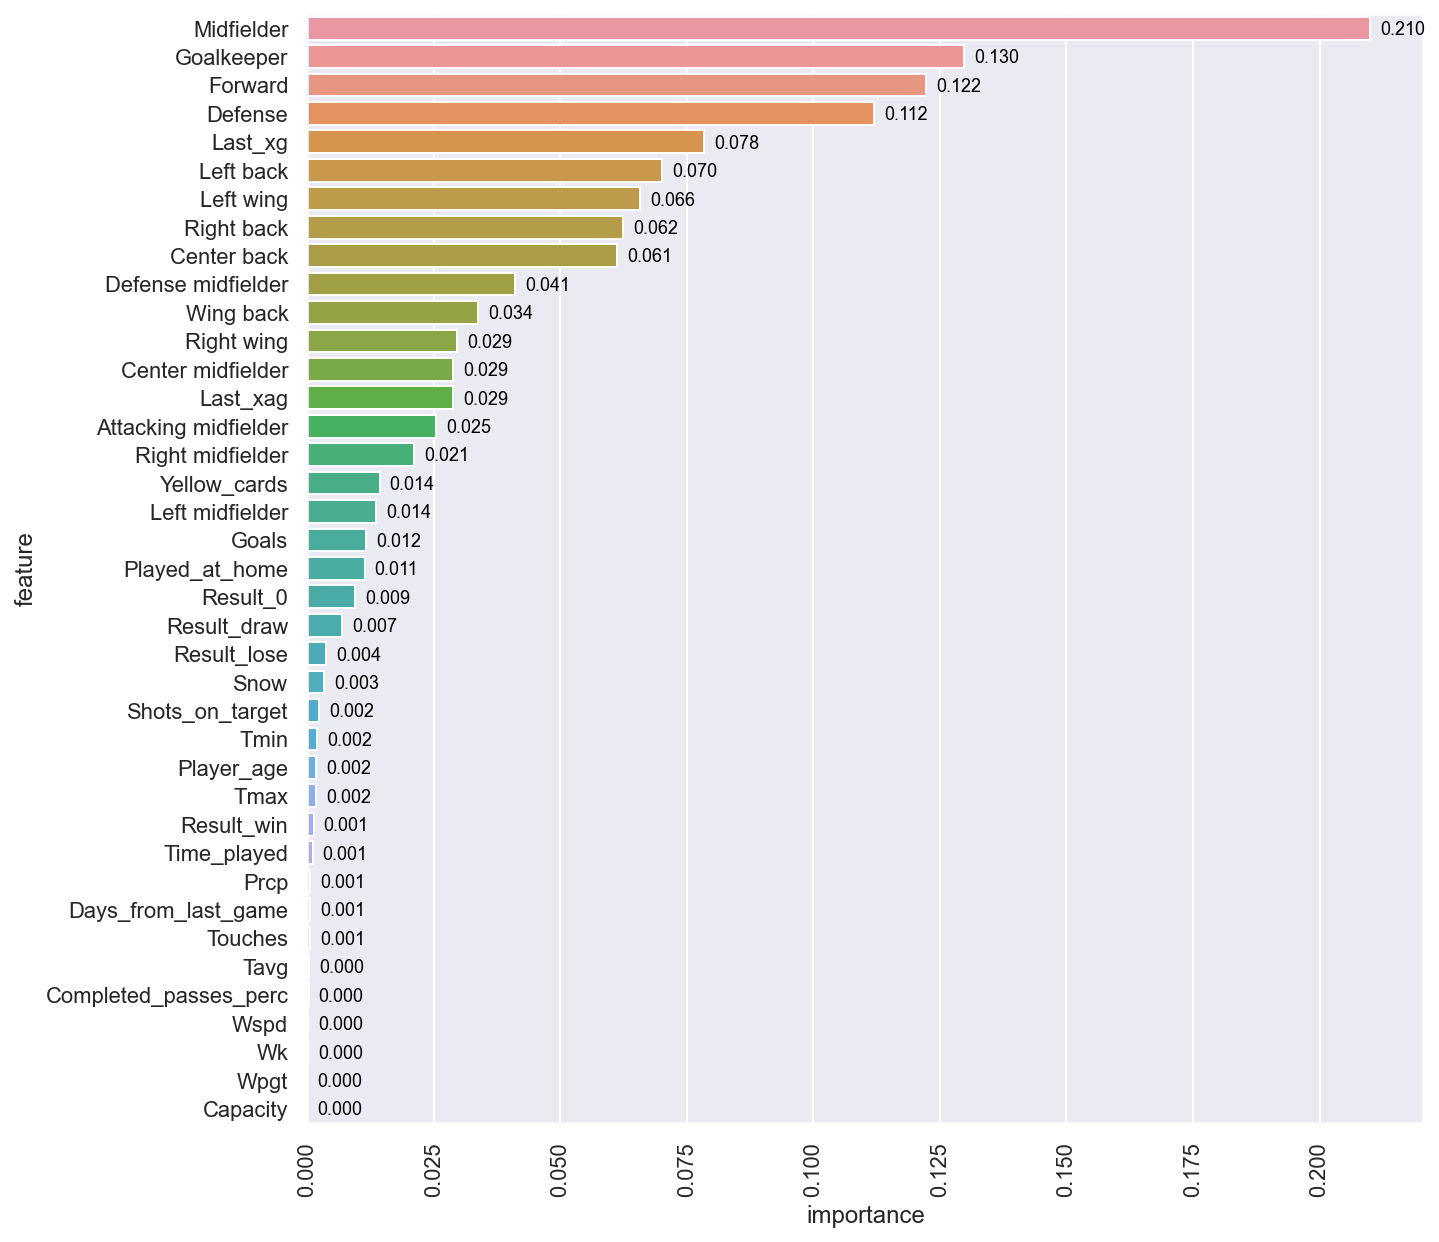

In [81]:
params = {'fit_intercept': True}
model = LinearRegression(**params)
X = pd.concat([X_train, X_test]).drop("player", axis=1)
y = pd.concat([y_train, y_test])

positions = {
    'AM': 'Attacking Midfielder',
    'CB': 'Center Back',
    'CM': 'Center Midfielder',
    'DF': 'Defense',
    'DM': 'Defense Midfielder',
    'FW': 'Forward',
    'GK': 'Goalkeeper',
    'LB': 'Left Back',
    'LM': 'Left Midfielder',
    'LW': 'Left Wing',
    'MF': 'Midfielder',
    'RB': 'Right Back',
    'RM': 'Right Midfielder',
    'RW': 'Right Wing',
    'WB': 'Wing Back'
}

model.fit(X,y)

importance = model.coef_
importances = []
# summarize feature importance
for i,v in enumerate(importance):
    importances.append([X.columns[i], abs(v)])
columns_importance = pd.DataFrame(importances, columns=['feature', 'importance'])
columns_importance.sort_values('importance', ascending=False, inplace=True)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# plt.figure(dpi=100, figsize=(12,4))
plt.figure(figsize=(10, 10), dpi=144)
ax = sns.barplot(y=columns_importance.feature.replace(positions).str.capitalize(), x=columns_importance.importance, orient='h')
for i, v in enumerate(columns_importance['importance']):
    ax.text(v+0.002, i+0.05, f'{v:.3f}', color='black', va='center',fontsize=9)
plt.xticks(rotation=90);
plt.show()

In [69]:
X = pd.concat([X_train, X_test]).drop("player_id", axis=1)
y = pd.concat([y_train, y_test])

params = {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 50, 'splitter': 'random'}
model = DecisionTreeRegressor(**params)
explainer, shap_values = regression_with_shap_value(X, y, model)
shap_values

.values =
array([[  1.89686484,  -1.15274083,  11.03441   , ...,  10.24207992,
         17.95402161,  -8.79863398],
       [  0.52560598,  -1.73957083, -17.66636199, ...,   8.81563779,
        -22.35283599,  -2.18781117],
       [  0.28990147,   0.57392524,  10.72981292, ...,  48.96449683,
         -0.26253562,  -0.72281089],
       ...,
       [  0.25833466,   1.75787289, -13.23874113, ...,  -8.37808162,
        -17.00504071,  -1.01452689],
       [  0.25833466,   1.75787289, -13.23874113, ...,  -8.37808162,
        -17.00504071,  -1.01452689],
       [  0.25833466,   1.0998198 ,  13.34064109, ...,  14.40805513,
        -37.13657304,  -1.01452689]])

.base_values =
array([[152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
   

In [70]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_values_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,1.896865,-1.152741,11.034410,-3.373381,0.0,0.0,16.761570,10.242080,17.954022,-8.798634
1,0.525606,-1.739571,-17.666362,-3.990069,0.0,0.0,12.288008,8.815638,-22.352836,-2.187811
2,0.289901,0.573925,10.729813,45.079716,0.0,0.0,2.642582,48.964497,-0.262536,-0.722811
3,0.258335,3.765761,1.307151,-6.302224,0.0,0.0,-16.528299,-5.176167,-10.687415,-1.014527
4,0.258335,1.757873,-11.904415,-8.702432,0.0,0.0,-20.867077,-8.378082,-10.687415,-1.014527
...,...,...,...,...,...,...,...,...,...,...
437,0.258335,1.757873,-13.395529,-8.581499,0.0,0.0,-20.020981,-12.186253,-6.355157,-1.014527
438,0.258335,3.765761,-0.027175,-6.302224,0.0,0.0,-8.876348,-5.176167,-17.005041,-1.014527
439,0.258335,1.757873,-13.238741,-8.702432,0.0,0.0,-13.215125,-8.378082,-17.005041,-1.014527
440,0.258335,1.757873,-13.238741,-8.702432,0.0,0.0,-13.215125,-8.378082,-17.005041,-1.014527


# Visualizações

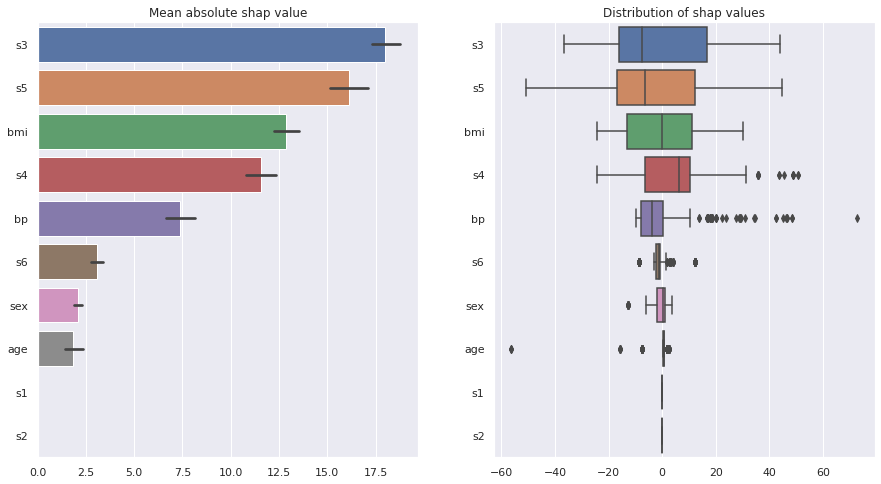

In [71]:
columns = shap_values_df.apply(np.abs).mean().sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.barplot(data=shap_values_df[columns].apply(np.abs).values, orient='h', ax=ax[0])
ax[0].set_title("Mean absolute shap value")
ax[0].set_yticklabels(columns)

sns.boxplot(data=shap_values_df[columns].values, orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values")
ax[1].set_yticklabels(columns);

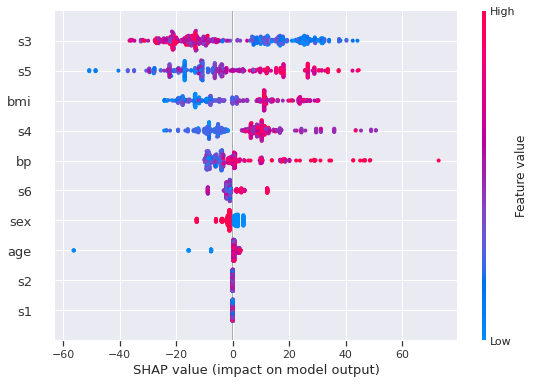

In [72]:
shap.summary_plot(shap_values)

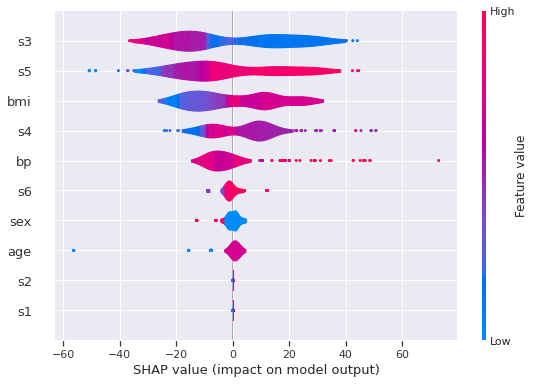

In [73]:
shap.summary_plot(shap_values, plot_type="violin")

In [77]:
shap.force_plot(explainer.expected_value, shap_values.values, X)

In [86]:
class WaterfallData():
    def __init__ (self, shap_test, index):
        self.values = shap_test[index].values
        self.base_values = shap_test[index].base_values[0]
        self.data = shap_test[index].data
        self.feature_names = shap_test.feature_names
        self.display_data = None

def plot_player(shap_values, index):
    shap.plots.waterfall(WaterfallData(shap_values, index))

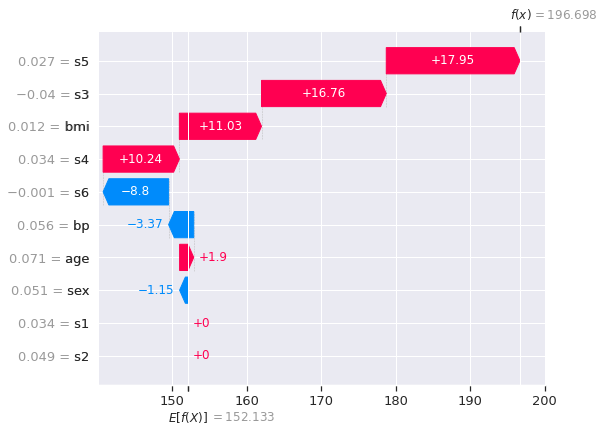

In [87]:
plot_player(shap_values, 0)